This is an off-shoot of the first draft of the bump attractor, this one will attempt to do a better job of reproducing the intertap interval graphs in the original paper, this will be through giving the input as a train of inter-tap intervals, the input to the bump attractor will be generated from this, and the intertap intervals will be generated one by one, with phase adjustments based on the difference between the produced and receieved intertap-interval.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [9]:
class attractor:
    def __init__(self, n_units, exc_spread=1, inp_scale=1, exc_scale = 1, inh_scale = 1, dop_scale = 1, n_noise_scale = 0, t_noise_scale = 0):
        
        #number of units in the line
        self.n_units = n_units

        #the input weight matrix just scales the input up or down, allows for adjusting of excitation while still using intuitive inputs (I think)
        self.W_input = np.identity(n_units) * inp_scale

        #generates the internal excitatory weight matrix, exc_spread controls how far excitatory connections reach, exc_scale controls how strong the excitatory connections are
        #its just a collections of Gaussians, exc_spread controls the sd
        self.W_exc = np.zeros((n_units,n_units))
        unit_ids = np.arange(0,n_units,1)        
        for i in range(0,n_units):
            ###the multiplying by n_units is because it is a pdf that decreases with the number of units involved, there might be a smarter way around this 
            ###but not using a pdf does not work so I will keep moving for now, either way I am not sure it makes a difference
            self.W_exc[i] = stats.norm.pdf(unit_ids, i, exc_spread) * n_units * exc_scale
        
        #there is tonic inhibition that scales with the total amount of activity in the network, similar to the basal ganglia
        self.W_inh = np.ones((n_units,n_units)) * (-1 * inh_scale)

        #the dopamine modulates the excitatory current, this is how strong the modulation is
        self.dop_scale = dop_scale

        #how strong the noise in the neuron's activation is
        self.n_noise_scale = n_noise_scale

        #how strong the noise in the tapping is (there will be some taps that are produced faster or slower then intended by a few milliseconds)
        self.t_noise_scale = t_noise_scale
        
        #just plotting the weights so they can be checked
        plt.figure(1)
        plt.imshow(self.W_exc, cmap="plasma")
        plt.colorbar()
        plt.title("W_exc matrix")

        plt.figure(2)
        plt.plot(self.W_exc[int(np.round(n_units/2,0))], color="steelblue")
        plt.title("Excitatory weights from unit "+str(int(np.round(n_units/2,0)))+" to all other units")
        plt.xlabel("Unit Number")
        plt.ylabel("Connection Strength")

        #just initializing these variables so I don't cause mistakes later due to not knowing how to code
        self.dopamine = 0
        self.input = 0
        self.simulation = 0        


    #simulates the attractor receiving the input 
    def run(self, stimulus, dopamine):

        #number of time points and time constant
        n_steps = len(stimulus)
        dt = 0.001
        unit_ids = np.arange(0,200,1) #this is used to define the input to the attractor later


        #storing these for later
        self.stimulus = stimulus
        self.dopamine = dopamine
        #vector to hold whether or not a tap is produced each step...
        self.tapout = np.zeros(len(stimulus))
        self.tapout[500] = 1
        #matrix to store the input to the attractor
        self.a_input = np.zeros((self.n_units, n_steps))

        #matrix to hold the activations of all the units
        activations = np.zeros((self.n_units, n_steps))
        
        #start with the assumption the person already knows the ISI at start of simulation (all of our cases will start with 500 ms or 50 steps)
        isi = 500
        #these are used to see if a tap and stimulus have arrived and need to be compared to eachother to make phase/tempo adjustments (nauseating code but what can you do)
        stim_here = 0
        tap_here = 0
        #this is even more gross, these are the indices at which the last tap or stimulus took place
        last_stim = 0
        last_tap = 100
        for i in range(0, n_steps-600):
            #now we need to set the new input to the bump attractor, I do not think we need to make it noisy, because there is already the Gaussin representing uncertainty but this can be changed easily
            self.a_input[:,i] = stats.norm.pdf(unit_ids, isi - 400, 20)
            #simulate the behavior of the bump attractor
            activations[:,i+1] = activations[:,i] + dt * (self.non_lin(np.matmul(self.W_input,self.a_input[:,i]) + np.matmul(self.W_exc,activations[:,i]) * dopamine[i] * self.dop_scale + np.matmul(self.W_inh,activations[:,i])) - activations[:,i] + np.random.uniform(low=-1,high=1,size=self.n_units) * self.n_noise_scale)

            if i>0: #probably easiest to have the stimulus always start on a tap, don't want this to cause errors tho
                if stimulus[i]==1:
                        #noting that there was a perceived stimulus
                        stim_here = 1
                        #reset perceived ISI based on most recent stimulus arrival
                        isi = i - last_stim
                        last_stim = i
            if self.tapout[i] == 1:
                    #noting that a tap has occured
                    tap_here = 1
                    last_tap = i
                    #if we have received stimuli from our own tap, note where the following tap would be, if phase adjustment does not occur
                    #calculate the current intertap interval from the bump attractor
                    iti = np.argmax(activations[:,i])+400 #uhhhhhhhhhhhhhh.....
                    #set the timing of the next tap (with noise)
                    next_tap = int(i+iti)
                    

            
            #if there is both a tap and stimulus awaiting error assesment we can now make a phase correction
            if tap_here + stim_here == 2:
                error = last_tap - last_stim #this represents how far apart the last tap and last stimulus were
                #now place the next tap in the output sequence at the phase adjusted location
                self.tapout[next_tap-int(error/3)] = 1
                #now we are waiting for the next set of taps and stimuli
                stim_here = 0
                tap_here = 0


        self.activations = activations 

        plt.figure(3)
        plt.imshow(self.a_input[:,1:1000])
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.colorbar()
        plt.title("Input")

        plt.figure(4)
        plt.imshow(activations[:,5000:7000])
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.colorbar()
        plt.title("Activations of all units")

        plt.figure(5)
        plt.plot(self.tapout,alpha=0.5, label="tapping")
        plt.plot(stimulus,alpha=0.5,label="stimulus")
        
        
        #calculate the inter-stimulus intervals
        stim_indices = [i for i in range(len(stimulus)) if stimulus[i]==1]
        ISI_report = np.diff(stim_indices)
        #calculate the inter-tap intervals
        tap_indices = [i for i in range(len(self.tapout)) if self.tapout[i]==1]
        print(tap_indices)
        ITI_report = np.diff(tap_indices)
        plt.figure(6)
        plt.plot(ISI_report, alpha=0.5, label="ISIs",marker='x')
        plt.plot(ITI_report, alpha=0.5, label="ITIs",marker="x")
        plt.xlabel('Stimulus Number')
        plt.ylabel('Inter-tap Interval (ms)')
        plt.legend()
        

        saliences = np.zeros(n_steps)
        for i in range(n_steps):
            saliences[i] = (np.argmax(activations[:,i]) + 400)/1000
        plt.figure(7)
        plt.plot(saliences[1:14000])
        plt.ylabel("most salient intertap interval")
        plt.xlabel("time")

        #commenting these figures out for now, they are just adding clutter
        '''
        plt.figure(5)
        plt.title("activations of various units")
        for i in range(10):
            x = random.randint(0,self.n_units-1)
            plt.plot(activations[x], label="unit "+str(x), alpha=0.5)
        plt.legend()

        '''
        plt.figure(10)
        plt.title("Activations at certain steps")
        plt.plot(activations[:,int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/4))))
        plt.plot(activations[:,int(n_steps/2)],label=str("Activations at time point "+str(int(n_steps/2))))
        plt.plot(activations[:,int(n_steps/2)+int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/2)+int(n_steps/4))))
        plt.plot(activations[:,int(n_steps-1)],label=str("Activations at time point "+str(int(n_steps-1))))
        plt.ylabel("activation")
        plt.xlabel("unit")
        #plt.legend()
        

        
        

    def non_lin(self, vec):
        
        vec = np.tanh(vec)
        for i in range(0,len(vec)):
            if vec[i] < 0:
                vec[i] = 0

        return vec

Again we can define some inputs here...

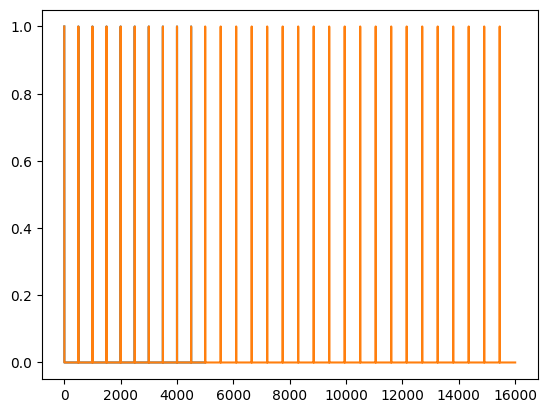

In [3]:
#stable input of 500 ms period metronome
stable_input = np.zeros(500 * 10)

for i in range(0,10):
    stable_input[i*500] = 1
    
#lets just add twenty 510 ms stimuli onto the end of stable_input
thaut_fig4a = np.zeros(510 * 20)

for i in range(0,20):
    thaut_fig4a[i*510] = 1 

thaut_fig4a = np.concatenate((stable_input,thaut_fig4a))

#same thing for 550ms stimuli
thaut_fig2a = np.zeros(550*20)

for i in range(0,20):
    thaut_fig2a[i*550] = 1 

thaut_fig2a = np.concatenate((stable_input,thaut_fig2a))


plt.plot(stable_input)
plt.plot(thaut_fig2a)



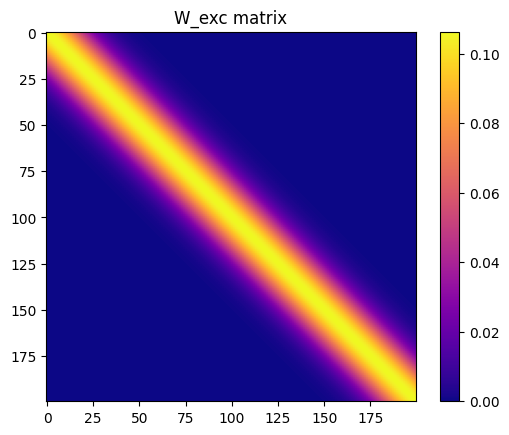

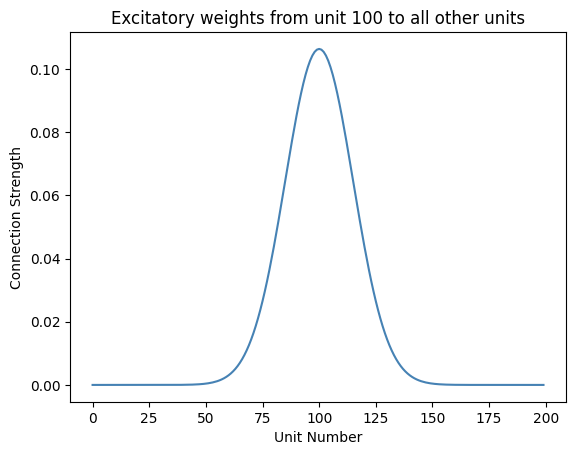

In [10]:
stable = attractor(n_units = 200, exc_spread = 15, inp_scale = 20, exc_scale = 0.02, inh_scale = 1.4, dop_scale = 8, n_noise_scale= 0.00)


[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6003, 6509, 7019, 7530, 8041, 8553, 9065, 9577, 10089, 10600, 11111, 11623, 12134, 12645, 13155, 13665, 14175, 14685]


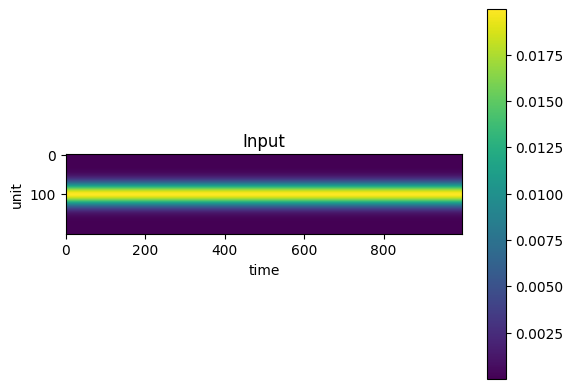

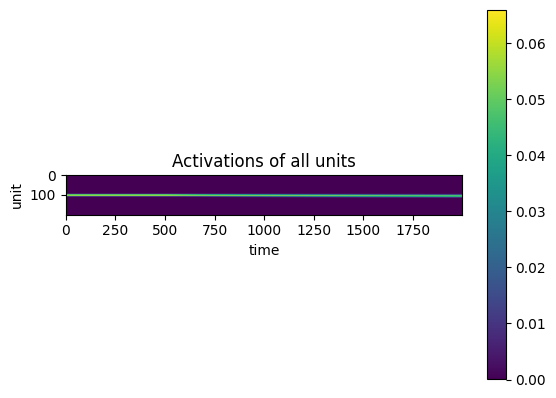

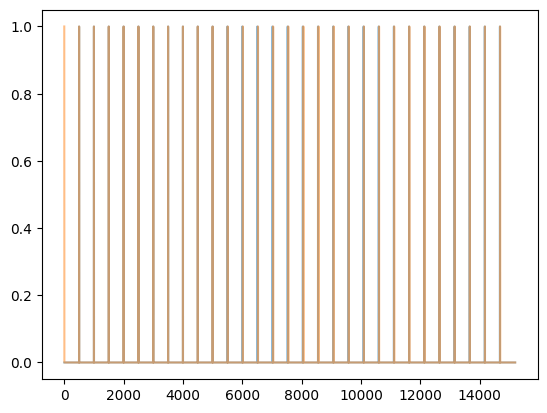

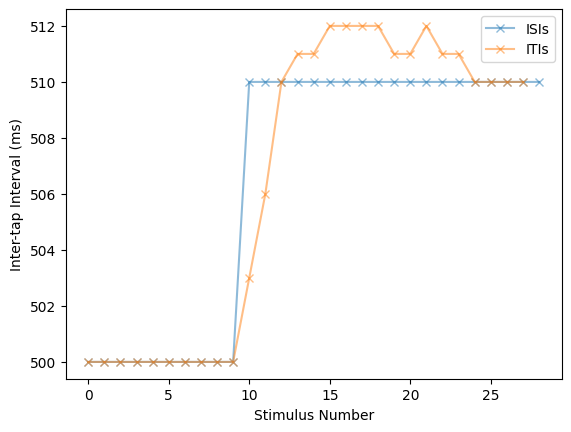

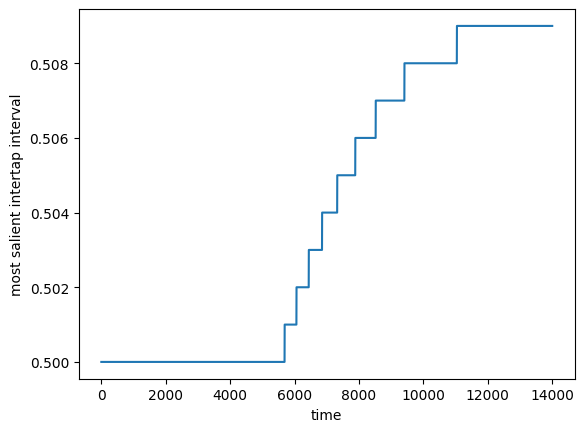

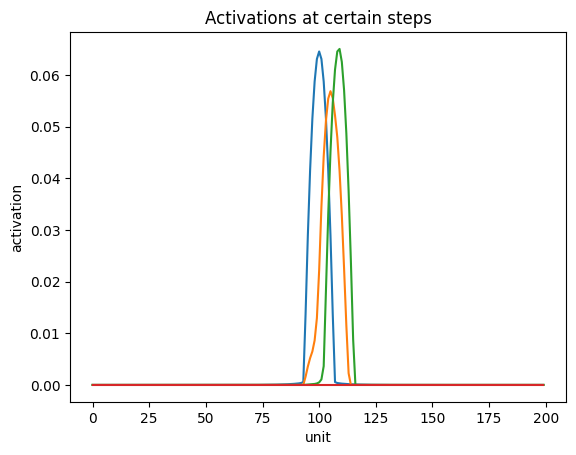

In [11]:
dopamine4a = np.ones(25000)
stable.run(stimulus = thaut_fig4a, dopamine = dopamine4a)

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6016, 6544, 7079, 7669, 8246, 8814, 9376, 9934, 10489, 11042, 11594, 12146, 12697, 13248, 13798, 14348, 14898, 15448]


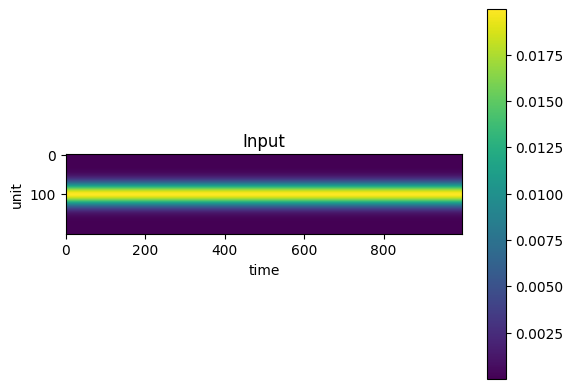

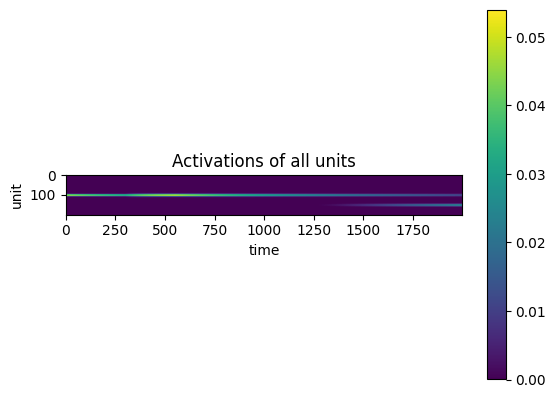

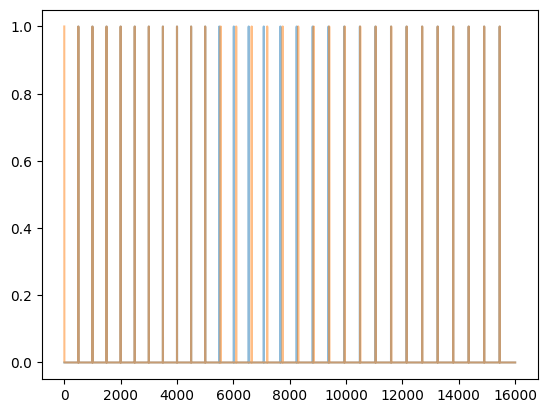

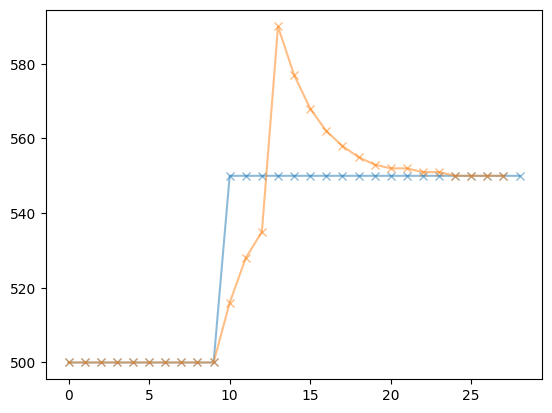

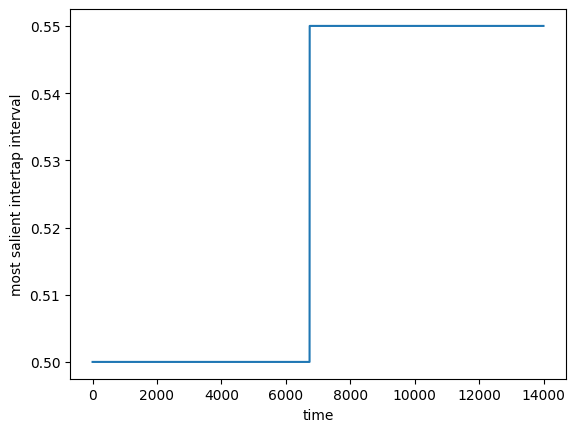

In [6]:
dopamine2a = np.ones(25000)
dopamine2a[4800:5300] = 0.01

stable.run(stimulus = thaut_fig2a, dopamine = dopamine2a)